In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [21]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

pneumonia-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D

import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import MobileNetV2

from imgaug import augmenters

In [25]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [26]:
batch_size = 32

img_height = 75
img_width = 75

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [28]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


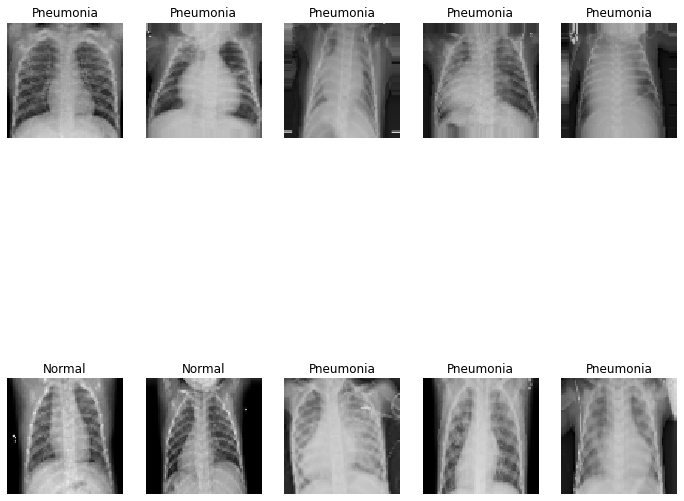

In [29]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [30]:
expert_conv = MobileNetV2(weights = 'imagenet', include_top = False,input_shape=(img_width,img_height,3))

for layer in expert_conv.layers:
      trainable = True
      layer.trainable = trainable


expert_model = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model.add(expert_conv)
expert_model.add(GlobalAveragePooling2D())

expert_model.add(Dense(128, activation = 'relu'))
expert_model.add(Dropout(0.3))
expert_model.add(Dense(64, activation = 'relu'))
expert_model.add(Dense(1, activation = "sigmoid"))

opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

expert_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

In [31]:
expert_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,430,273
Trainable params: 2,396,161
Non-trainable params: 34,112
_______________________________________

In [32]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [33]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [34]:
expert_model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
131/131 [==============================] - 175s 1s/step - loss: 0.6353 - accuracy: 0.5942 - val_loss: 0.4579 - val_accuracy: 0.8192
Epoch 2/25
131/131 [==============================] - 166s 1s/step - loss: 0.3304 - accuracy: 0.8645 - val_loss: 0.3538 - val_accuracy: 0.8481
Epoch 3/25
131/131 [==============================] - 166s 1s/step - loss: 0.2374 - accuracy: 0.9075 - val_loss: 0.2885 - val_accuracy: 0.8798
Epoch 4/25
131/131 [==============================] - 171s 1s/step - loss: 0.2119 - accuracy: 0.9175 - val_loss: 0.2385 - val_accuracy: 0.9115
Epoch 5/25
131/131 [==============================] - 166s 1s/step - loss: 0.1687 - accuracy: 0.9377 - val_loss: 0.2024 - val_accuracy: 0.9317
Epoch 6/25
131/131 [==============================] - 165s 1s/step - loss: 0.1760 - accuracy: 0.9312 - val_loss: 0.1886 - val_accuracy: 0.9298
Epoch 7/25
131/131 [==============================] - 165s 1s/step - loss: 0.1446 - accuracy: 0.9443 - val_loss: 0.1760 - val_accuracy: 0.9337

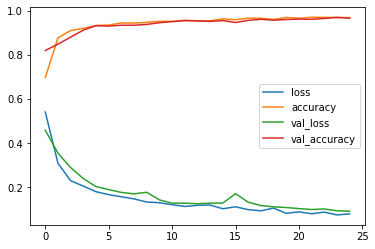

In [35]:
pd.DataFrame(expert_model.history.history).plot()

In [36]:
test_accu = expert_model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

20/20 [==============================] - 9s 422ms/step - loss: 0.3469 - accuracy: 0.8734
The testing accuracy is -  87.33974099159241 %


In [37]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [38]:
y_bar = np.round(expert_model.predict(test)).reshape(-1)
y_act = test.labels

In [39]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.8733974358974359
ROC-AUC score:  0.8963831177985978
F1 score:  0.906064209274673
Log Loss:  4.372709185216051
